## In this project, I will use a **scikit-learn** and **Cost Complexity Pruning** to bulid a **Clasification tree**, which use continuous and categorical data from the **UCI Machnie Learning Repository** to predict whether or not a patient has **heart disease** :

In [2]:
import pandas as pd # to load and manipulate data and for one-hot encoding
import numpy as np # to calculate the mean and standard deviation
import matplotlib.pyplot as plt # to draw graphs
from sklearn.tree import DecisionTreeClassifier # to build a classification tree
from sklearn.tree import plot_tree #to draw a classification tree
from sklearn.model_selection import train_test_split # to split data into training and testing sets
from sklearn.model_selection import cross_val_score # for cross validation
from sklearn.metrics import confusion_matrix # to create a confusion matrix
from sklearn.metrics import plot_confusion_matrix # to draw a confusion matrix

In [3]:

# load the data set
df = pd.read_csv('http://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data', header=None)

In [1]:

# rename the column names
df.columns = ['age','sex','cp','restbp',
             'chol','fbs','restecg','thalach','exang','oldpeak','slope','ca','thal','hd']
df.describe()


NameError: name 'df' is not defined

## **Missing Data Part1: Identifying Missing Data** 
There are two main ways to deal with missing data:

1. We can remove the rows that contain missing data from the dataset.

2. We can impute the missig value with the average age or the medium age, or use some other, more sophisticated approach to guess at an approprite value. 

In [11]:
#dtypes tells us the "data types" of each column
df.dtypes

age        float64
sex        float64
cp         float64
restbp     float64
chol       float64
fbs        float64
restecg    float64
thalach    float64
exang      float64
oldpeak    float64
slope      float64
ca          object
thal        object
hd           int64
dtype: object

In [12]:
#print out unique values in the column call-ed "ca"
df['ca'].unique()

array(['0.0', '3.0', '2.0', '1.0', '?'], dtype=object)

The question mark, which indicates missing value in 'ca' variable.

In [11]:
# print out unique values in the column called "ca"
df['thal'].unique()

array(['6.0', '3.0', '7.0', '?'], dtype=object)

## **Missing Data Part2: Dealing Missing Data** 

In [8]:
## print out the number if rows that contain missing values.
len(df.loc[(df['ca']=='?')|(df['thal']=='?')])

6

In [9]:
# print out these 6 rows which contain missing data
df.loc[(df['ca']=='?')|(df['thal']=='?')]

,age,sex,cp,restbp,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,hd
87,53.0,0.0,3.0,128.0,216.0,0.0,2.0,115.0,0.0,0.0,1.0,0.0,?,0
166,52.0,1.0,3.0,138.0,223.0,0.0,0.0,169.0,0.0,0.0,1.0,?,3.0,0
192,43.0,1.0,4.0,132.0,247.0,1.0,2.0,143.0,1.0,0.1,2.0,?,7.0,1
266,52.0,1.0,4.0,128.0,204.0,1.0,0.0,156.0,1.0,1.0,2.0,0.0,?,2
287,58.0,1.0,2.0,125.0,220.0,0.0,0.0,144.0,0.0,0.4,2.0,?,7.0,0
302,38.0,1.0,3.0,138.0,175.0,0.0,0.0,173.0,0.0,0.0,1.0,?,3.0,0


6 of the 303 rows, or 2% contain missing values. The rest of 297 is plenty of data to build classification tree, we will remove the rows with missing values, rather than tru to impute their values.

In [17]:
#use loc() to select all rows that do not contain missing values
#and save them in a new datafram called "df_no_missing"

df_no_missing = df.loc[(df['ca']!='?')&(df['thal']!='?')]


In [18]:
X= df_no_missing.iloc[:,:-1] # make a new copy of the columns used to make predictions
# alternative: X= df_no_missing.drop('hd',axis=1).copy

In [19]:
# make a new copy of the column of data we want yo predict
y= df_no_missing['hd'].copy()
y.head()

0    0
1    2
2    1
3    0
4    0
Name: hd, dtype: int64

Now we have created X, which has the data we want to use make predictors, and y, which has the data we want to predict. We are ready to continue formating X so that it is suitable for making a Decision tree.

In [38]:
len(df_no_missing)

297

In [20]:
df_no_missing['ca'].unique()

array(['0.0', '3.0', '2.0', '1.0'], dtype=object)

In [27]:
df_no_missing['thal'].unique()

array(['6.0', '3.0', '7.0'], dtype=object)

## **Format Data : Split the Data into Dependent and Independent Variables**

In [21]:
# for this tutorial, we will use get_dummies() to do One-Hot Encoding.
## ColumnTransformer() is a alternative option.
pd.get_dummies(X, columns=['cp']).head()

,age,sex,restbp,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,cp_1.0,cp_2.0,cp_3.0,cp_4.0
0,63.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,1,0,0,0
1,67.0,1.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,0,0,0,1
2,67.0,1.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,0,0,0,1
3,37.0,1.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0,0,1,0
4,41.0,0.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0,1,0,0


In [22]:
# use get_dummies on the four categorical columns that have more than 2 categories and save the results
X_encoded = pd.get_dummies(X,columns=['cp',
                                     'restecg',
                                     'slope',
                                     'thal'])
X_encoded.head()

,age,sex,restbp,chol,fbs,thalach,exang,oldpeak,ca,cp_1.0,...,cp_4.0,restecg_0.0,restecg_1.0,restecg_2.0,slope_1.0,slope_2.0,slope_3.0,thal_3.0,thal_6.0,thal_7.0
0,63.0,1.0,145.0,233.0,1.0,150.0,0.0,2.3,0.0,1,...,0,0,0,1,0,0,1,0,1,0
1,67.0,1.0,160.0,286.0,0.0,108.0,1.0,1.5,3.0,0,...,1,0,0,1,0,1,0,1,0,0
2,67.0,1.0,120.0,229.0,0.0,129.0,1.0,2.6,2.0,0,...,1,0,0,1,0,1,0,0,0,1
3,37.0,1.0,130.0,250.0,0.0,187.0,0.0,3.5,0.0,0,...,0,1,0,0,0,0,1,1,0,0
4,41.0,0.0,130.0,204.0,0.0,172.0,0.0,1.4,0.0,0,...,0,0,0,1,1,0,0,1,0,0


The outcome y has 5 different level of heart disease,0= no disease, 1-4 are various degrees of heart disease. We can see this with unique():


In [42]:
y.unique()

array([0, 2, 1, 3, 4])

In this project, we only make a tree that does simple classifiction and only care if someone has heart disease or not, so we need to convert all numbers >0 t0 1.

In [23]:
y_not_zero_index = y>0 # get the index for each non-zero value in y
y[y_not_zero_index]=1 # set each non_zero value in y to 1.
y.unique()

array([0, 1])

## **Bulid A Preliminary Classification Tree**


In [32]:
# split the data into trsining and testing data,defalut split 0.7/0.3.
X_train, X_test,y_train,y_test=train_test_split(X_encoded, y, random_state=42)
# "random_state=42 " the same as set.seed()
# create a desicion tree and fit it to the training set
clf_dt = DecisionTreeClassifier(random_state=42)
clf_dt=clf_dt.fit(X_train,y_train)

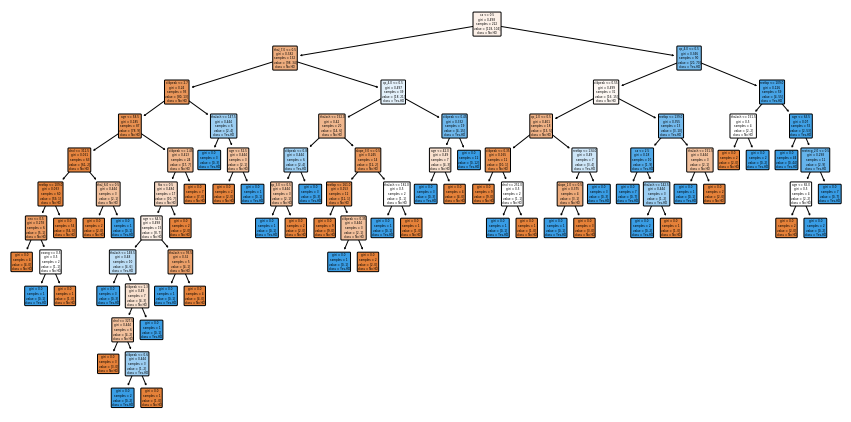

In [19]:
plt.figure(figsize=(15,7.5))
plot_tree(clf_dt,
         filled=True,
         rounded=True,
         class_names=["No HD","Yes,HD"],
         feature_names=X_encoded.columns);

We have built a **Classification Tree** for classsification. Let us see jow it performs on the **Testing Dataset** by running the **Testing Data** down the tree and drawing a **Confusin Matrix**

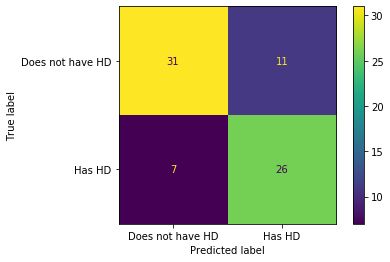

In [20]:
# polt confusion matrix will run the test set down the tree and draw a confusion matrix
plot_confusion_matrix(clf_dt,X_test, y_test,display_labels=["Does not have HD","Has HD"])

In confusion matrix, we see that of the 31+11=42 people that did not have heart disease,31(74%) were correctly classified.And if the 7+26=33 people that have heart disease,26(79%) were correctly classified. Can we do better? One thing that might be holding this classification tree back is that itmay have overfit the training data. Prune the tree should solve the overfit problem and give a better result.

## **Cost Complexity Pruning Part 1: Visualize alpha**

**Decision Trees** are notorious for being  **overfit** to the **Trainig Dataset**, and there are a lot of parameters, like `max_depth` and `min_samples`, that are desinged to reduce overfitting. However, pruning a tree with **cost complexity pruning** can simplify the whole process of findind a smaller tree that improves the accuracy with the **Testing Dataset**.

Pruning a decision tree is all about finding the right value for the pruning parameter, alpha, which controls how little or how much pruning happens. One way to find the optimal value for alpha is to plot the accuracy of the tree  as a function of different values. We will do thid for both the **Training Dataset** and the **Testing Dataset**.

First, let us extract the different values of alpha that are avaliable for this tree and build a pruned tree for each value for alpha.

In [30]:
path= clf_dt.cost_complexity_pruning_path(X_train,y_train) # determine values of alpha
ccp_alphas= path.ccp_alphas # extract different values for alpha
ccp_alphas=ccp_alphas[:-1] #exclude the maximum value for alpha

clf_dts=[]# create an arry that we will put decision trees into

## now create one decision tree per value for alpha abd store it in the array
for ccp_alpha in ccp_alphas:
    clf_dt= DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha)
    clf_dt.fit(X_train,y_train)
    clf_dts.append(clf_dt)

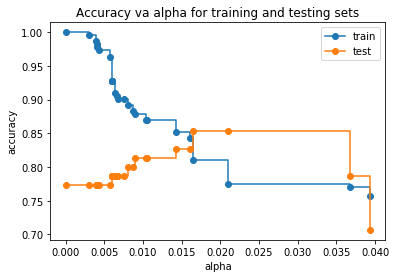

In [31]:
# graph the accuracy of the trees using the training dataset and the test dataset as a function of alpha
train_scores = [clf_dt.score(X_train, y_train) for clf_dt in clf_dts]
test_scores = [clf_dt.score(X_test, y_test) for clf_dt in clf_dts]

fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy va alpha for training and testing sets")
ax.plot(ccp_alphas, train_scores, marker = "o", label = "train", drawstyle="steps-post")
ax.plot(ccp_alphas, test_scores, marker = "o", label = "test", drawstyle="steps-post")
ax.legend()
plt.show()



In the graph above, we see that the accuracy for the **Testing Dataset** hits its maximum value when `alpha` is about 0.016. After this value for `alpha`, the accuracy of the **Training Dataset** drops and that suggests we should set `ccp_alpha=0.016`.

**Note**L: When we apply **Cost complexity pruning** to a **Classification Tree**, values for `alpha` ranges form 0 to 1. In contrast, values for `alpha` for a **Regression Tree** can be much larger since the sum of squared residuals can, in theroy, goes from 0 to positive infinity.

Since there are many ways we could have divided the original dataset into **Training** and **Testing** datasets, how do we used the best **Training Dataset** and how do we know we used the best **Testing Dataset**? Typically, we answer this question with **10-fold cross validation**. So the next I will do it with the `cross_val_score()`function.



## **Cost Complexity Pruning Part 2: Cross Validation For Finding the Best Alpha**

The graph we just drew suggested one value for alpha,**0.016**, but another set of data might suggest anpther optimal value. 

First, let's demonstrate that different training and testing datasets result with differnt accuracies when we set `ccp_alpha=0.016`. We will do this by using the `cross_val_score()` function to generate different training and testing datasets and the train and test the tree with those datasets.


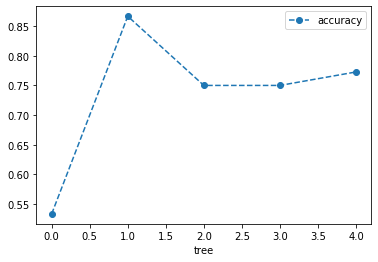

In [38]:
clf_dt = DecisionTreeClassifier (random_state=42, ccp_alpha=0.016) # create the tree with ccp_alpha=0.016

#now use 5-fold CV create 5 different training and testing datasets set that are then used to train and test the tree

scores = cross_val_score(clf_dt, X_train, y_train, cv=5)
df = pd.DataFrame(data={'tree': range(5),'accuracy': scores})

df.plot(x= 'tree', y='accuracy', marker='o',linestyle ='--')


The graph above that using different **Training** and **Testing** data with the same`alpha` resulted in different accuracies, suggesting that `alpha` is sensitive to the dataset. So, instead of picking a single **Training** dataset and single **Testing** datasets, I will use **CV** to find the optimal value for `ccp_alpha`.

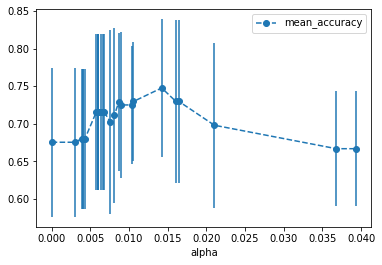

In [45]:
# create an array to store the results for each fold during cv
alpha_loop_values = []

# for each candidate values for alpha, I will run 5 fold cv and store the mean and sd of the scores for each call to cv in alpha_loop_values
for ccp_alpha in ccp_alphas:
    clf_dt = DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha)
    scores = cross_val_score(clf_dt, X_train,y_train,cv=5)
    alpha_loop_values.append([ccp_alpha, np.mean(scores), np.std(scores)])
    
# Now we can draw  a graph of the means and sd of the scores for each candidate value for alpha
alpha_results = pd.DataFrame(alpha_loop_values, columns=['alpha','mean_accuracy','std'])

alpha_results.plot(x = 'alpha',
                  y = 'mean_accuracy',
                  yerr="std",
                  marker='o',
                  linestyle='--')

Using the cv, we can see that, overall, instead of setting `ccp_alpha=0.016`, we need to set it to something closer to 0.014. We can find the exact value with:


In [46]:
alpha_results[(alpha_results['alpha']>0.014) & (alpha_results['alpha']< 0.015)]

,alpha,mean_accuracy,std
20,0.014225,0.747778,0.091395


Now let us store the optimal value for alpha so that we can use it to build the best tree.

In [48]:
ideal_ccp_alpha = alpha_results[(alpha_results['alpha']>0.014) & (alpha_results['alpha']< 0.015)]['alpha']
ideal_ccp_alpha

# convert ideal_ccp_alpha from a series to a float
ideal_ccp_alpha = float(ideal_ccp_alpha)
ideal_ccp_alpha

0.014224751066856332

  
## **Building, Evaluating, Drawing, and Interpreting the Final Classification Tree**

Now that I got the ideal value for `alpha` we can build final **Classification Tree** by selecting `ccp_alpha=ideal_ccp_alpha`:

In [53]:
## build and train a new decision tree, only this time use the optimal value for alpha

clf_dt_pruned = DecisionTreeClassifier(random_state=42, ccp_alpha=ideal_ccp_alpha)

clf_dt_pruned = clf_dt_pruned.fit(X_train,y_train)

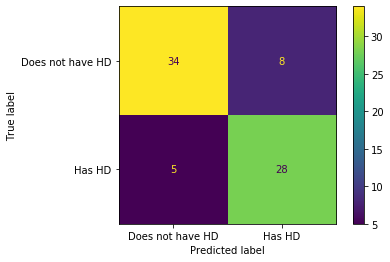

In [54]:
## draw tha confusion matrix to see if the pruned tree does better:
plot_confusion_matrix(clf_dt_pruned, X_test,y_test, display_labels = ["Does not have HD","Has HD"])

Of the 34+8=42 people that did not have heart disearse, 34(81%) were correctly classified. This is an improvement over the full size tree, which only correctly classified 31(74%) of the patients without heart disease. Of the 5+28=33 people with heart disease, 28(85%) were correctly classified. Again, this is an improvement over the full size tree, which only correctly classifier 26(79%) of the patiens with heart dosease.

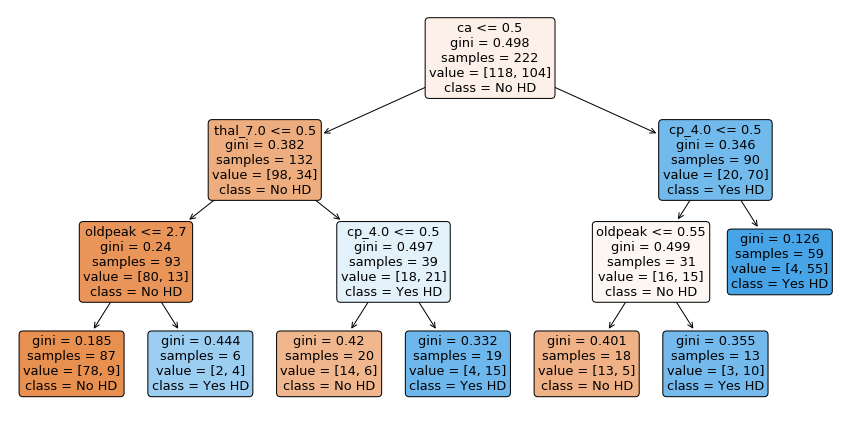

In [62]:
## draw the pruned tree and interpret it
plt.figure( figsize= (15,7.5))
plot_tree(clf_dt_pruned,
         filled=True,
         rounded=True,
         class_names=['No HD','Yes HD'],
         feature_names=X_encoded.columns);

In each nodes, we have:
* The variable and the threshold for splitting the observations,For example, in the tree's root, we use `ca` to split the observations. All obsevations with **`ca`<=0.5** go to the left and all ovservation with **`ca`>0.5** go to the right.
* **gini** is the gini index or socre for the node.
* **samples** tell us how many samples are in the nodes.
* **value** twll us how many samples in the node are in each category. In this example, we have two categories, **No** and **Yes**, referring to where or not a patient has heart disease. The number of patients with **No** comes first because the categories are in the alphabetical order. Thus, in the root, 118 patients have **No** and 104 patients have **Yes**.
* **class** tells us whichever category id represent the most in the node. In thr root, since 118 people have **No** and only 104 patients have **Yes**, class is set to **No**.